Plate detection and recognition

In [278]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def show_image(img, color=False):
    if color:
        plt.imshow(img)
        plt.show()
    else:
        plt.imshow(img, 'gray')
        plt.show()

Prosecna visina: 89.08
Prosecna sirina: 287.82
Prosecan aspect ratio: 3.25


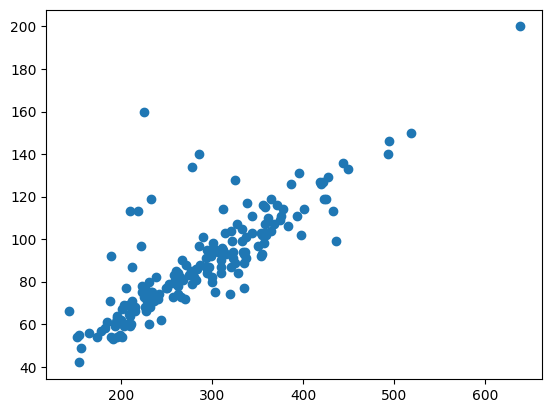

In [3]:
positive_images = []
negative_images = []

folder_path = '../datasets/train/'

aspect_ratios = []
widths = []
heights = []

for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = load_image(img_path)
    if 'plate' in img_name:
        positive_images.append(img)
        width = img.shape[1]
        height = img.shape[0]
        heights.append(height)
        widths.append(width)
        aspect_ratios.append(width/height)

    elif 'neg' in img_name:
        negative_images.append(img)

print(f'Prosecna visina: {sum(heights)/len(positive_images):.2f}')
print(f'Prosecna sirina: {sum(widths)/len(positive_images):.2f}')
avg_aspect_ratio = sum(aspect_ratios) / len(aspect_ratios)
print(f'Prosecan aspect ratio: {avg_aspect_ratio:.2f}')
plt.scatter(widths, heights)
plt.show()


In [4]:
new_width = 200
new_height = int(new_width / avg_aspect_ratio)

for i, img in enumerate(positive_images):
    positive_images[i] = cv2.resize(img, (new_width, new_height))

for i, img in enumerate(negative_images):
    negative_images[i] = cv2.resize(img, (new_width, new_height))


In [5]:
positive_features = []
negative_features = []
labels = []

nbins = 9
cell_size = (8, 8)
block_size = (3, 3)

hog = cv2.HOGDescriptor(_winSize=(new_width // cell_size[1] * cell_size[1], 
                                  new_height // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

for img in positive_images:
    positive_features.append(hog.compute(img))
    labels.append(1)

for img in negative_images:
    negative_features.append(hog.compute(img))
    labels.append(0)

positive_features = np.array(positive_features)
negative_features = np.array(negative_features)
x = np.vstack((positive_features, negative_features))
y = np.array(labels)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=42)

svm = SVC(kernel='linear', probability=True)
svm.fit(x_train, y_train)

y_train_pred = svm.predict(x_train)
y_val_pred = svm.predict(x_val)
print(f'Train accuracy:{accuracy_score(y_train, y_train_pred)}')
print(f'Validation accuracy:{accuracy_score(y_val, y_val_pred)}')


Train accuracy:1.0
Validation accuracy:0.9857142857142858


In [7]:
def evaluate_window(window):
    features = hog.compute(window).reshape(1, -1)
    return svm.predict_proba(features)[0][1]

In [8]:
def detectPlate(image, step, window_size):
    best_score = 0
    best_window = None
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if window.shape == (window_size[1], window_size[0]):
                score = evaluate_window(window)
                if score > best_score:
                    best_score = score
                    best_window = (y, x)
    return best_score, best_window


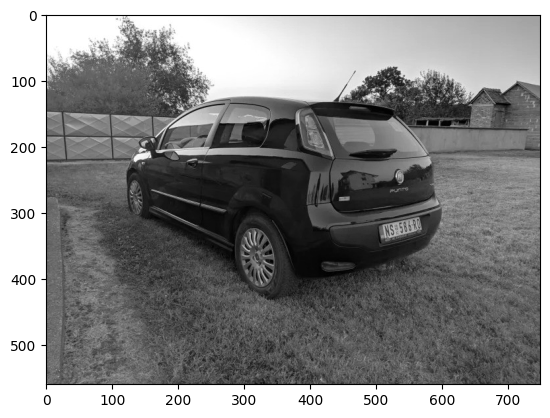

In [9]:
img = load_image('/home/stefan/Downloads/test5.jpg')
show_image(img)

necemo koristiti cv2.pyrDown(image)


In [10]:
def gaussian_pyramid(image, num_levels=3, ksize=(5,5)):
    images = []
    images.append(image)

    for i in range(num_levels-1):
        image = cv2.GaussianBlur(image, sigmaX=0, ksize=ksize)
        width = int(image.shape[1] / 1.3)
        height = int(image.shape[0] / 1.3)
        image = cv2.resize(image, (width, height))
        images.append(image)

    return images

0.11956808278674727


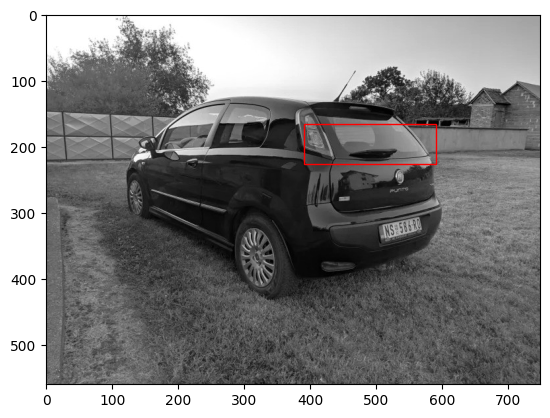

0.3514699335569377


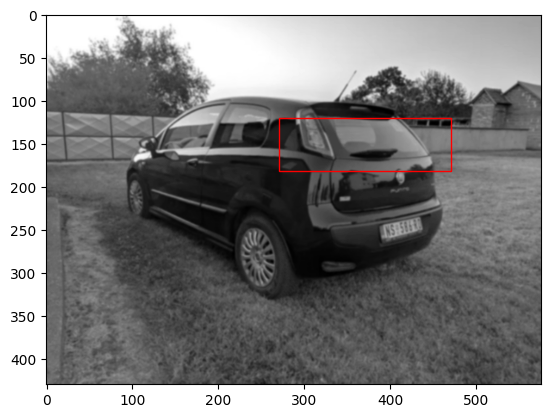

0.06157741374692417


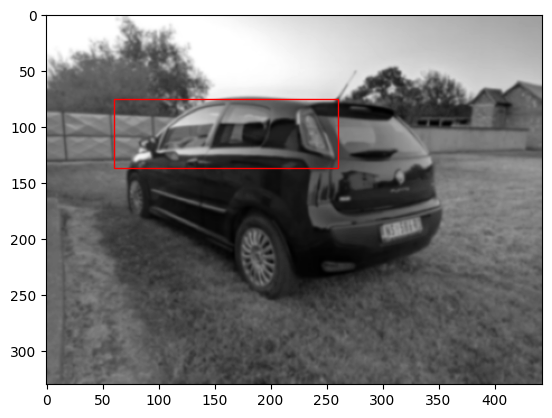

0.06581105491778229


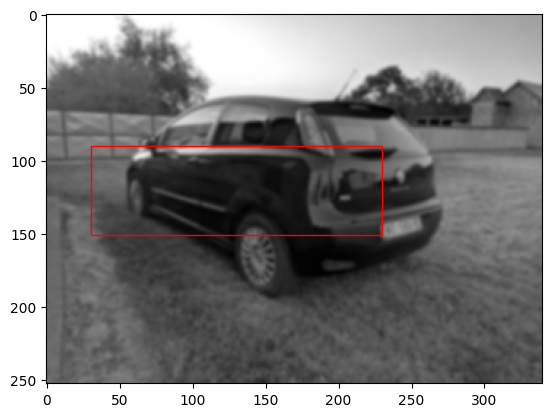

0.012000954854889053


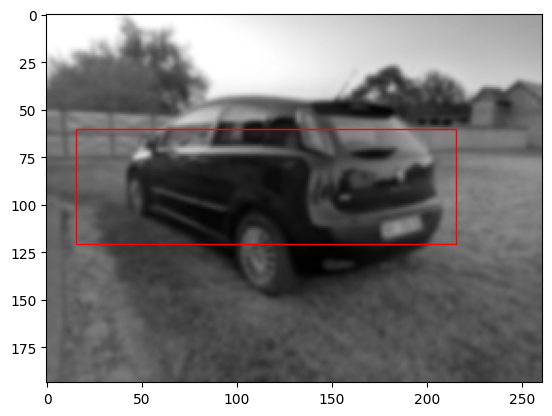

In [11]:
images = gaussian_pyramid(img, num_levels=5)
boxes = []
scores = []
for img in images:  
    score, window = detectPlate(img, 15, (new_width, new_height))
    y, x = window
    x2 = x + new_width
    y2 = y + new_height
    window2 = (x, y, x2, y2)
    scores.append(score)
    boxes.append(window2)
    print(score)
    rect = plt.Rectangle((x, y), new_width, new_height, edgecolor='r', facecolor='none')
    plt.imshow(img, cmap='gray')
    plt.gca().add_patch(rect)
    plt.show()


In [12]:
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def dilate(image, kernel_shape=(3, 3), iter=1):
    kernel = np.ones(kernel_shape)
    return cv2.dilate(image, kernel, iterations=iter)

def erode(image, kernel_shape=(3, 3), iter=1):
    kernel = np.ones(kernel_shape)
    return cv2.erode(image, kernel, iterations=iter)

def resize_region(region, shape=(28, 28)):
    return cv2.resize(region, shape, interpolation=cv2.INTER_NEAREST)

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

In [262]:
def merge_0(contours):
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    horizontal_gap = 12
    merged_contours = []
    remaining_contours = contours.copy()
    indices_to_remove = []
    
    for i, contour1 in enumerate(contours):
        x1, y1, w1, h1 = cv2.boundingRect(contour1)
        area = cv2.contourArea(contour1)
        if area > 90 and area < 1000 and w1 > 5 and w1 < 35 and h1 > 10 and i not in indices_to_remove:
            lower = y1 + h1
            for j, contour2 in enumerate(contours):
                if i != j and j not in indices_to_remove:
                    x2, y2, w2, h2 = cv2.boundingRect(contour2)
                    upper = y2
                    if lower > upper and abs(lower - upper) < 10 and abs(x2 - x1) <= horizontal_gap:
                        x_merged = min(x1, x2)
                        y_merged = min(y1, y2)
                        w_merged = max(x1 + w1, x2 + w2) - x_merged
                        h_merged = max(y1 + h1, y2 + h2) - y_merged

                        merged_contour = np.array([[x_merged, y_merged, w_merged, h_merged]])
                        merged_contours.append(merged_contour)

                        indices_to_remove.extend([i, j])
    
    indices_to_remove = list(set(indices_to_remove))
    
    remaining_contours = [contour for i, contour in enumerate(remaining_contours) if i not in indices_to_remove]

    return merged_contours, remaining_contours



In [263]:
def select_roi_test(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = []
    regions_array = []
    merged_contours, remaining_contours = merge_0(contours)
    for contour in remaining_contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 150 and area < 1000 and h < 100 and h > 20 and w > 5 and w < 100:
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    for contour in merged_contours:
        x, y, w, h = contour[0]
        if  h < 100 and h > 20 and w > 5 and w < 100:
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)

    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

In [125]:
def select_roi_train(image_orig, image_bin):
    image_bin2 = erode(image_bin, (3, 1), 2)        # da bih spojio kvacice
    contours, hierarchy = cv2.findContours(image_bin2.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = []
    regions_array = []
    y_sub = 4
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 700 and h < 100 and h > 40 and w > 10:
            y +=y_sub
            h -= 2 * y_sub
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

In [284]:
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def create_cnn(output_size):
    cnn = Sequential()
    cnn.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                    input_shape=(28, 28, 1)))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))
    cnn.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
    cnn.add(Dropout(0.2))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))
    cnn.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))
    cnn.add(Flatten())
    cnn.add(Dense(units=512, activation="relu"))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(units=output_size, activation="softmax"))
    
    cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return cnn

def train_cnn(cnn, train, validation, epochs):

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
    
    print("\nTraining started...")
    history = cnn.fit(train, epochs=epochs, verbose=1, validation_data=validation, callbacks=callbacks)
    print("\nTraining completed...")
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    return cnn

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

In [15]:
folder = '../datasets/font/val/'
full_alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Z', 'Č', 'Ć', 'Ž', 'Đ', 'Š', 'W', 'Y']
img = load_image('../datasets/font/plate_font.png')
img_bin = image_bin(img)
selected_img, sorted_regions = select_roi_train(img.copy(), img_bin)
for i, region in enumerate(sorted_regions):
    if not os.path.exists(folder+full_alphabet[i]) and full_alphabet[i] not in 'ČĆŽĐŠWY':       # nemamo ČĆŽĐŠWY
        os.makedirs(folder+full_alphabet[i])
        putanja = os.path.join(folder+full_alphabet[i], full_alphabet[i] + '.png')
        slika = Image.fromarray(region.astype('uint8'))
        slika.save(putanja)

In [16]:
train_datagen = ImageDataGenerator(rotation_range=4)
test_datagen = ImageDataGenerator(rescale=None) # treba mi samo da bi automatski dodao labele

In [17]:
alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Z']
batch_size = 16

train_generator = train_datagen.flow_from_directory(
        '../datasets/font/train/', 
        batch_size=batch_size,
        color_mode='grayscale',
        target_size=(28, 28),
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '../datasets/font/val/',
        batch_size=batch_size,
        color_mode='grayscale',
        target_size=(28, 28),
        class_mode='categorical')

Found 353 images belonging to 33 classes.
Found 33 images belonging to 33 classes.



Training started...
Epoch 1/200
23/23 [==============================] - 6s 125ms/step - loss: 2.7630 - accuracy: 0.3286 - val_loss: 6.3673 - val_accuracy: 0.3030
Epoch 2/200
23/23 [==============================] - 2s 93ms/step - loss: 0.6448 - accuracy: 0.8527 - val_loss: 1.9370 - val_accuracy: 0.6364
Epoch 3/200
23/23 [==============================] - 2s 96ms/step - loss: 0.2044 - accuracy: 0.9575 - val_loss: 1.0561 - val_accuracy: 0.6364
Epoch 4/200
23/23 [==============================] - 2s 80ms/step - loss: 0.0972 - accuracy: 0.9830 - val_loss: 0.4887 - val_accuracy: 0.7576
Epoch 5/200
23/23 [==============================] - 2s 89ms/step - loss: 0.0895 - accuracy: 0.9915 - val_loss: 0.5074 - val_accuracy: 0.8182
Epoch 6/200
23/23 [==============================] - 2s 99ms/step - loss: 0.0318 - accuracy: 0.9972 - val_loss: 0.1361 - val_accuracy: 0.9697
Epoch 7/200
23/23 [==============================] - 2s 98ms/step - loss: 0.0267 - accuracy: 0.9943 - val_loss: 0.1900 - val_a

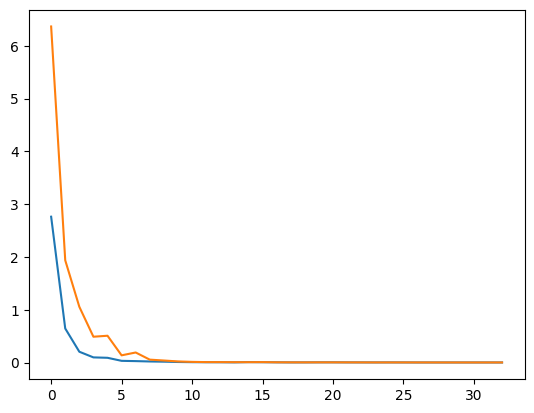

In [280]:
cnn = create_cnn(output_size=(len(alphabet)))
cnn = train_cnn(cnn, train_generator, validation_generator, epochs=200)

In [283]:
print(cnn.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)       

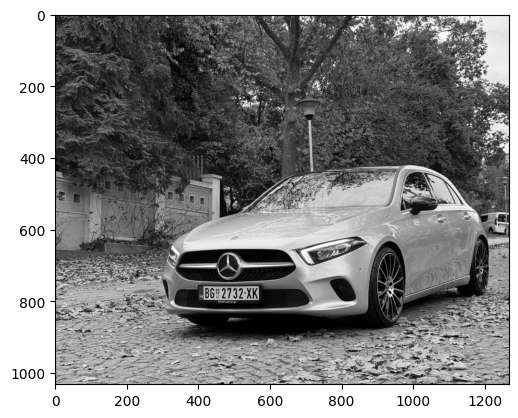

0.9812215443495559


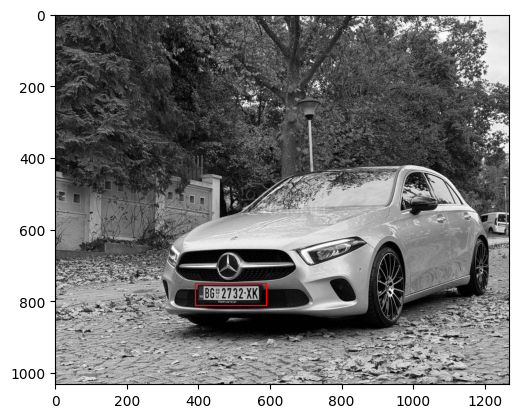

In [268]:
img = load_image('/home/stefan/Downloads/test4.jpg')
show_image(img)
score, window = detectPlate(img, 15, (new_width, new_height))
y, x = window
x2 = x + new_width
y2 = y + new_height
window2 = (x, y, x2, y2)
print(score)
rect = plt.Rectangle((x, y), new_width, new_height, edgecolor='r', facecolor='none')
plt.imshow(img, cmap='gray')
plt.gca().add_patch(rect)
plt.show()

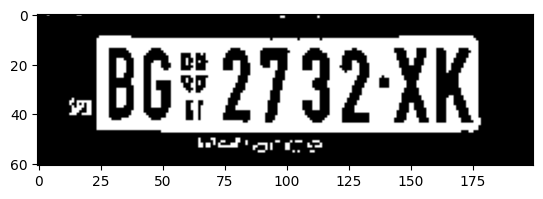

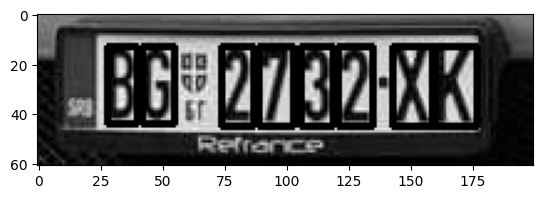

1/1 [==============================] - 0s 119ms/step
['8', 'G', '2', '7', '3', '2', 'X', 'K']


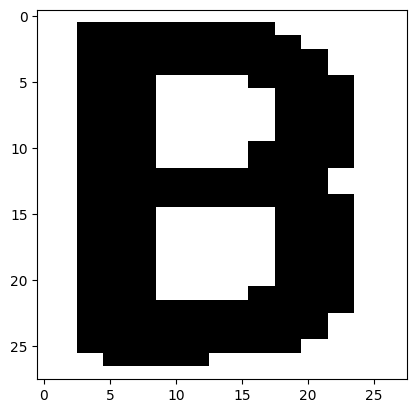

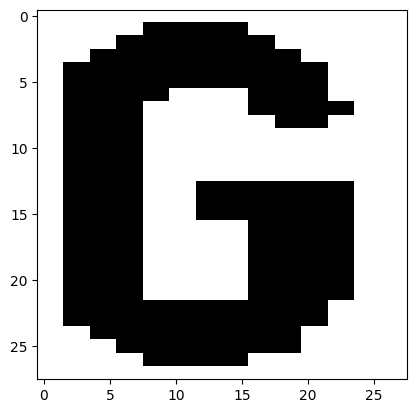

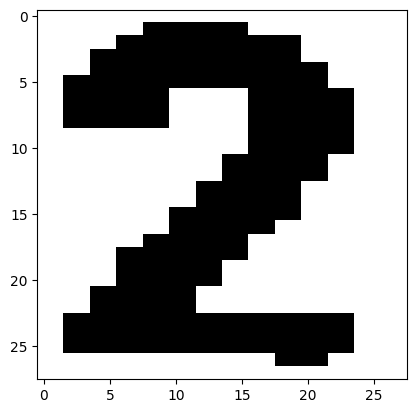

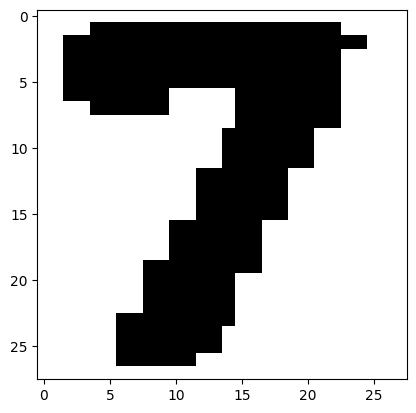

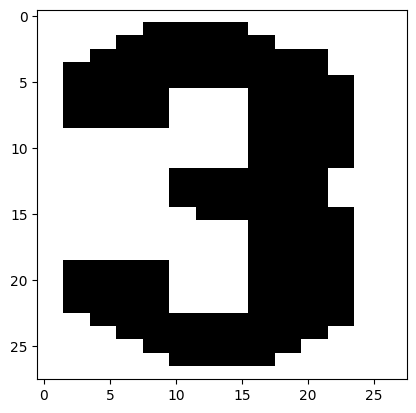

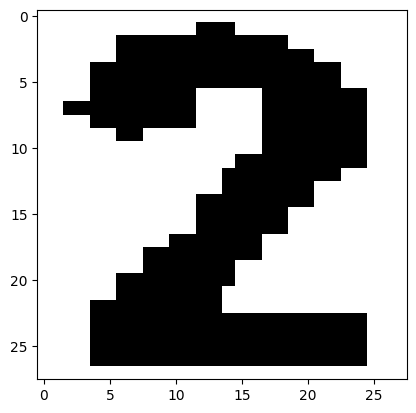

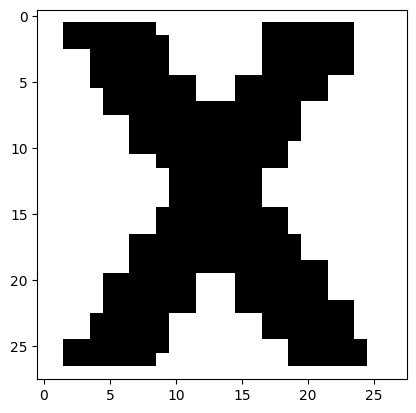

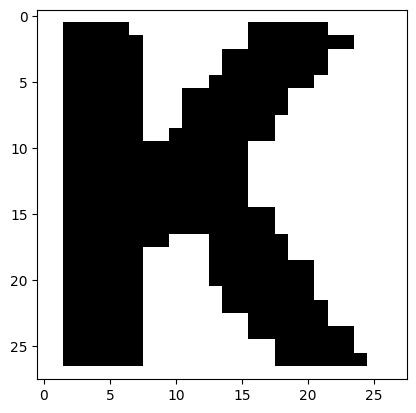

In [282]:
img = load_image('/home/stefan/Downloads/test4.jpg')

plate = img[y:y+new_height, x:x+new_width]
plate_bin = image_bin(plate)
show_image(plate_bin)

selected_img, sorted_regions = select_roi_test(plate.copy(), plate_bin)
show_image(selected_img)
result = cnn.predict(np.array(sorted_regions, np.float32))
print(display_result(result, alphabet))

for region in sorted_regions:
    show_image(region)
    